# PH30110: Computational Astrophysics Python Coursework 
<div class="alert alert-block alert-danger">
</div>

This notebook demonstrates the application of numerical methods to simulate the orbit of Halley's Comet around the Sun, three body systems as well as three body systems in the centre of mass frame. The simulation employs the Runge-Kutta method (RK4) for solving the ordinary differential equations governing the motion of the comet under the influence of the Sun's gravitational field. The adaptive time-stepping technique is utilised to ensure accuracy and efficiency in the integration process. Finally, the Runge-Kutta Fehlberg (RKF45) and velocity-Verlet methods are implemented to compare to the adaptive RK4 method. The results include visualisations of the celestial objects trajectory, distance from the central star, and velocity over time, providing insights into the dynamics of dynamical orbits. 

The accompanying report explains the methods, results and conclusions in detail, and should be used in conjunction with this script.

## Initialisation 

In [2]:
# Importing the libraries required for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import time
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
# Setting the plotting parameters
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

In [4]:
# Fundamental Constants
AU = c.au.value # m 
G = c.G.value # m^3 kg^-1 s^-2
M_sun = c.M_sun.value # kg
Year = 365.25 * 24 * 60 ** 2 # s

## Q1a - Basic RK4 Model with no adaptive timestep 

In this section, the basis basic Runge-Kutta 4th order (RK4) method is implemented to simulate the orbit of Halley's Comet around the Sun using fixed time-steps. The initial conditions for the comet's position and velocity at aphelion (furthest point away) are set, and the RK4 method is used to integrate the equations of motion over time. The code iterates through each timestep, updating the position and velocity of the comet using the RK4 method. The results are stored in lists for later analysis and visualisation. The trajectory of the comet is plotted to show its orbit around the Sun. This basic RK4 model provides a foundation for understanding the dynamics of cometary orbits and serves as a benchmark for comparing more advanced methods, such as those with adaptive timesteps.

In [5]:
r_aphelion = 5.2e12 # m - Furtherest distance away from the sun
v_aphelion = 880 # m/s -  Speed at aphelion (will be only in y-direction)

Total steps taken were 3800.0, with a total time of 76.0 years. Runtime was 0.05 seconds.


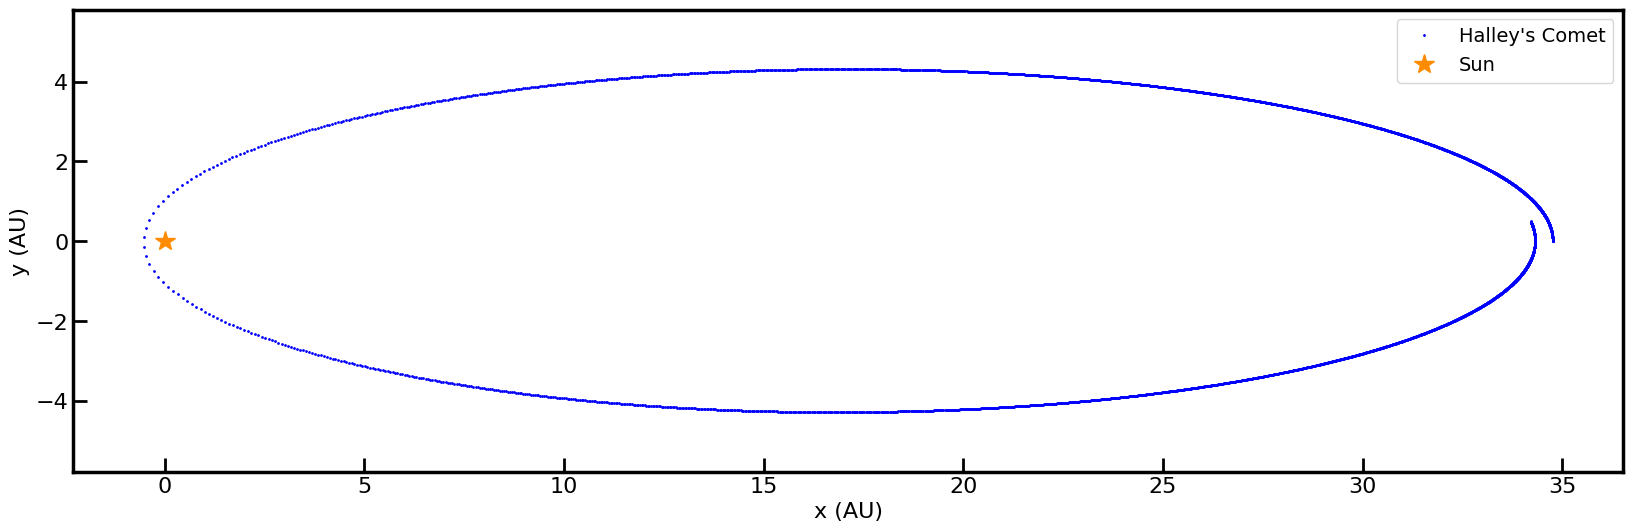

In [6]:
# Gravitational acceleration due to the Sun
def acceleration(f):
    x, y, vx, vy = f # State vector in SI units 
    r2 = x * x + y * y
    r = np.sqrt(r2)
    # Avoid division by Zero in event it is at the origin 
    if r > 1e-12:
        ax = -G * M_sun * x / (r2 * r)
        ay = -G * M_sun * y / (r2 * r)
    else:
        ax = ay = 0.0
    return np.array([vx, vy, ax, ay], dtype=np.float64)
    
# One Runge-Kutta step
# f is state vector, dt is time step
def rk4_step(f, dt):
    k1 = dt * acceleration(f)
    k2 = dt * acceleration(f + 0.5 * k1)
    k3 = dt * acceleration(f + 0.5 * k2)
    k4 = dt * acceleration(f + k3)
    return f + (k1 + 2 * k2 + 2 * k3 + k4) / 6.0

# Integration of the orbit
def run_simulation(r_aphelion, v_aphelion, end_years):
    x, y = [], []
    current_t, steps_taken = 0.0, 0.0
    start_time = time.time()
    # Initial state: [x, y, vx, vy]
    f = np.array([r_aphelion, 0, 0, v_aphelion], dtype=np.float64)

    step = Year / 50          # Fixed step size 
    end_time = end_years * Year  # Total time to simulate

    while current_t < end_time:
        f = rk4_step(f, step)  # Update state vector

        # Store results
        x.append(f[0])
        y.append(f[1])

        current_t += step
        steps_taken += 1

    runtime = time.time() - start_time
    return x, y, steps_taken, end_time, runtime

x, y, steps_taken, end_time, runtime = run_simulation(r_aphelion,
                                                   v_aphelion, 
                                                   end_years = 76)

print(f"Total steps taken were {steps_taken}, with a total time of {end_time / Year} years. Runtime was {runtime:.2f} seconds.")

# Plot orbit
plt.figure(figsize=(20, 6))
plt.plot(np.array(x) / AU, np.array(y) / AU, '.', label="Halley's Comet", markersize=2, color='blue')
plt.plot(0, 0, '*', color='darkorange', markersize=15, label="Sun")
plt.xlabel('x (AU)'), plt.ylabel('y (AU)')
plt.axis('equal')
plt.legend()
plt.show()

The plot above makes use of a fixed step size, and varying this alters the accuracy of the orbit. There is a large dependance on the step size, and the plot below aims to demonstrate this. It is clear to see, that as the step size decreases, the orbit stays in a more stable shape, while for larger step sizes the variance in shape is very clear. The code builds on that above, defining four step sizes to be tested, and creating a 2x2 plot to display the results. 

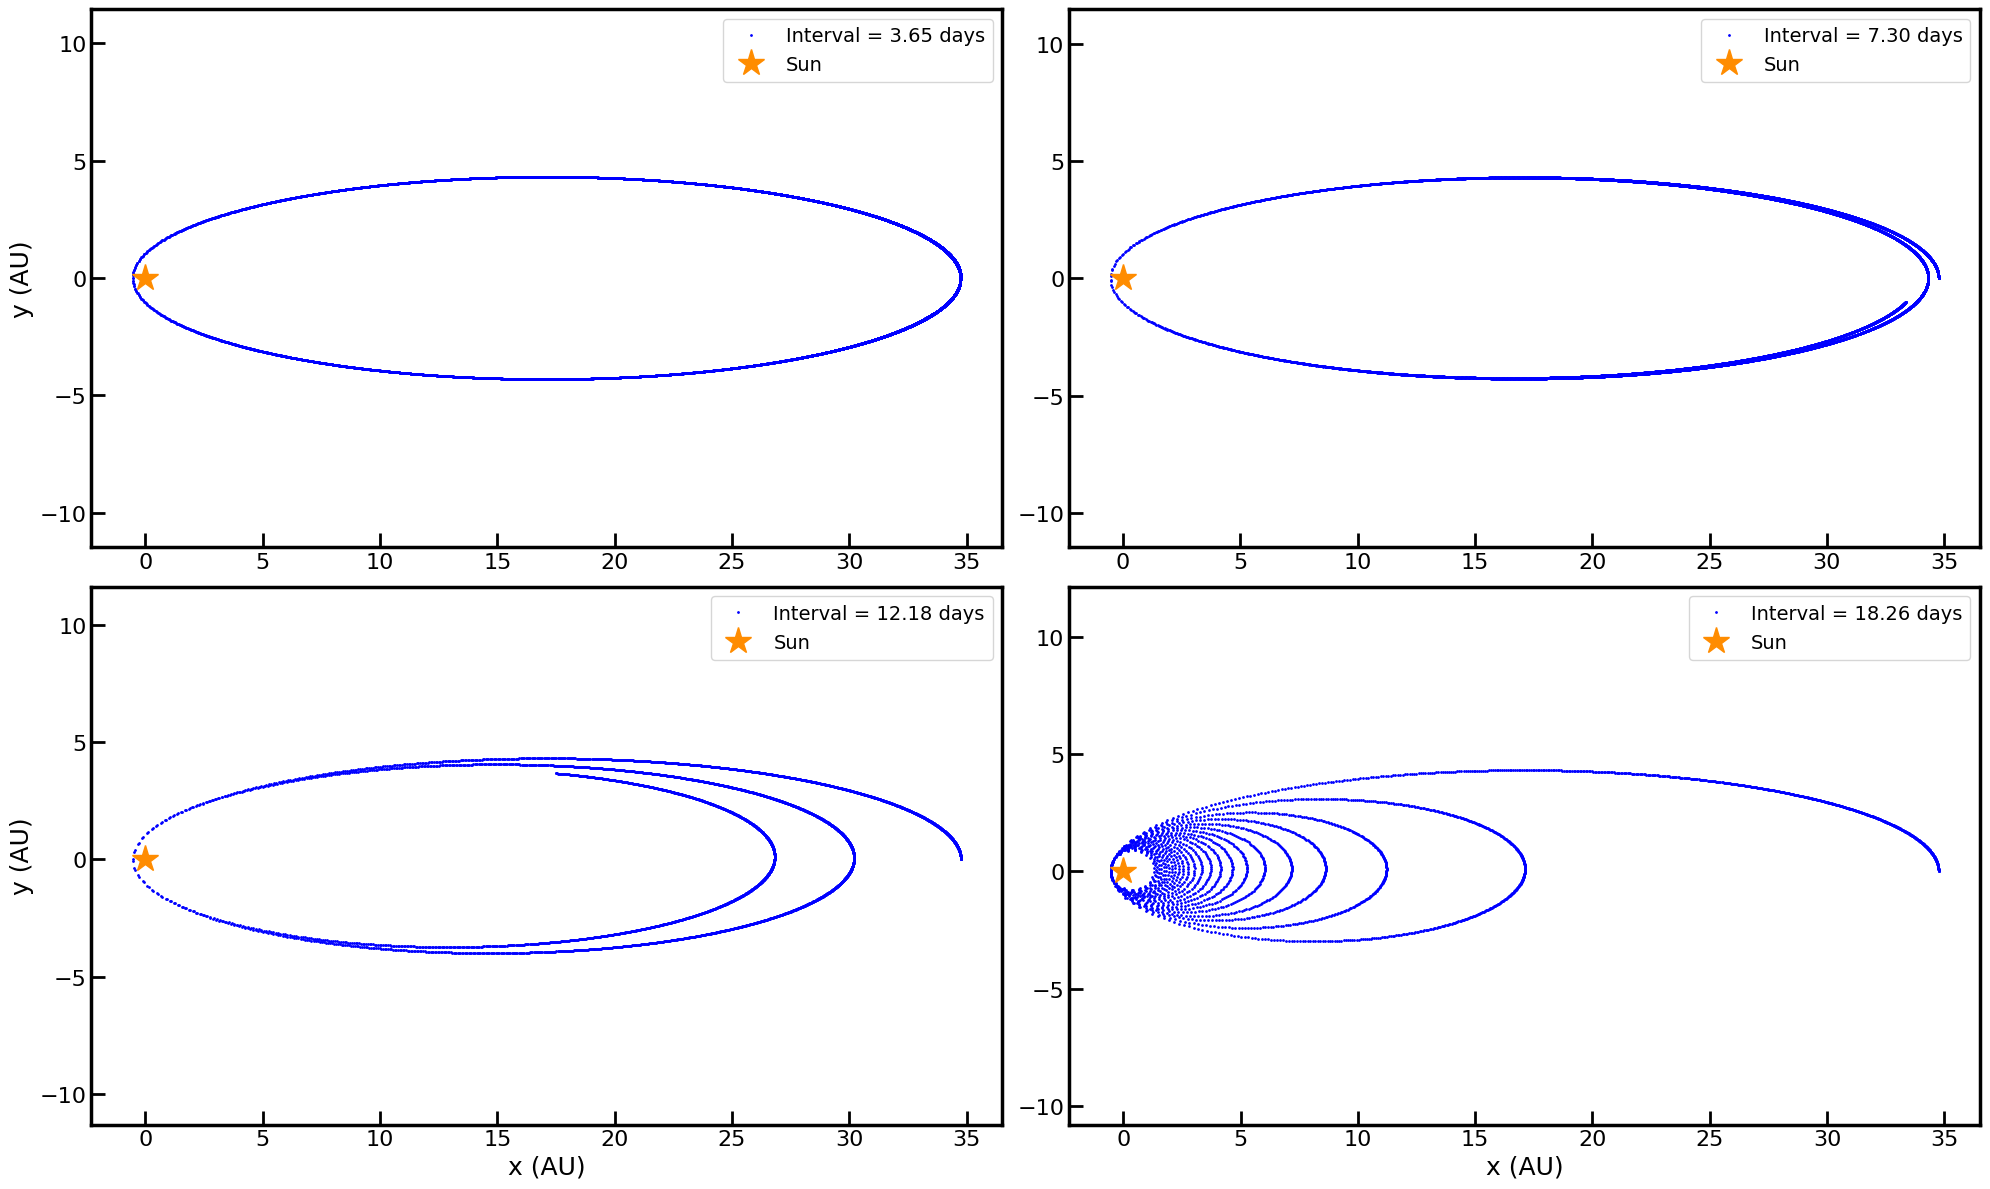

In [7]:
# Time steps and total simulation time
time_steps = [Year / 100, Year / 50, Year / 30, Year / 20]
end_t = 140 * Year  # Simulate for 140 years

fig, axs = plt.subplots(2, 2, figsize=(20, 12))
# Loop over time_steps
for i, dt in enumerate(time_steps):
    x, y = [], []
    current_t, steps_taken = 0.0, 0.0
    # Initial state: [x, y, vx, vy]
    f = np.array([r_aphelion, 0, 0, v_aphelion], dtype=float)
    while current_t < end_t:
        f = rk4_step(f, dt)  # Update state vector

        # Store results
        x.append(f[0])
        y.append(f[1])

        current_t += dt
        steps_taken += 1
    ax = axs[i // 2, i % 2]
    ax.plot(np.array(x) / AU, np.array(y) / AU, label=f"Interval = {(dt / 86400):.2f} days", 
            color='blue', markersize=2, linestyle='None', marker='.')
    ax.plot(0, 0, '*', color='darkorange', markersize=20, label="Sun")
    # Formatting where axis labels are placed
    if i // 2 == 1:
        ax.set_xlabel('x (AU)', fontsize=18)
    else:
        ax.set_xlabel('')
    if i % 2 == 0:
        ax.set_ylabel('y (AU)', fontsize=18)
    else:
        ax.set_ylabel('')

    ax.axis('equal')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Q1b - Improved Method

### Adaptive RK4

The below code improves on the fixed time step method from question 1a. A summary of the improvements are below, however for full explanation see the report. 

1. Adaptive Time Stepping (dt) - The original code uses a fixed time step, with the below code now using an adaptive time step. The code below dynamically adjusts dt based on error estimates, making it more accurate and efficient. 
2. Use of Classes - The classes `comet` and `Runsimulation` were introduced to make the code more modular and easily reusable. 
3. Error Correction  - The adaptive step also builds in the error correction factor to adjust the step dynamically. This aims to increase the accuracy
4. History storage - The code below uses `self.comet.history` to store the entire `f_vec` (Force Vector) at each step. This makes the code more structured and easier to extend. 
5. The plot - The new code introduces a trajectory with velocty plot, providing additional insight into speed variations over the orbital path 
6. Performance - The adaptive step uses less memory, and stores fewer points in history. This is due to `dt` being larger where changes in the path are slow (aphelion). The number of steps are outputted to demonstrate the saving in computing power. 
7. Time Step Plot - This enables a visualisation into how the adaptive step method worked over time, plotting the variation in `dt`. 
8. Energy Plot - The Kinetic, Potential and Total energy are computed for the comet. This enables an insight as to whether conservation of these quantities is obeyed. A best fit is applied to the Total energy, and gradient outputted/ 

The below is the full code, repeating functions such as acceleration. The idea is that from this point forward, this can act as a base to utilise features for further testing. 

Simulation finished in 0.02 s with 176 steps.


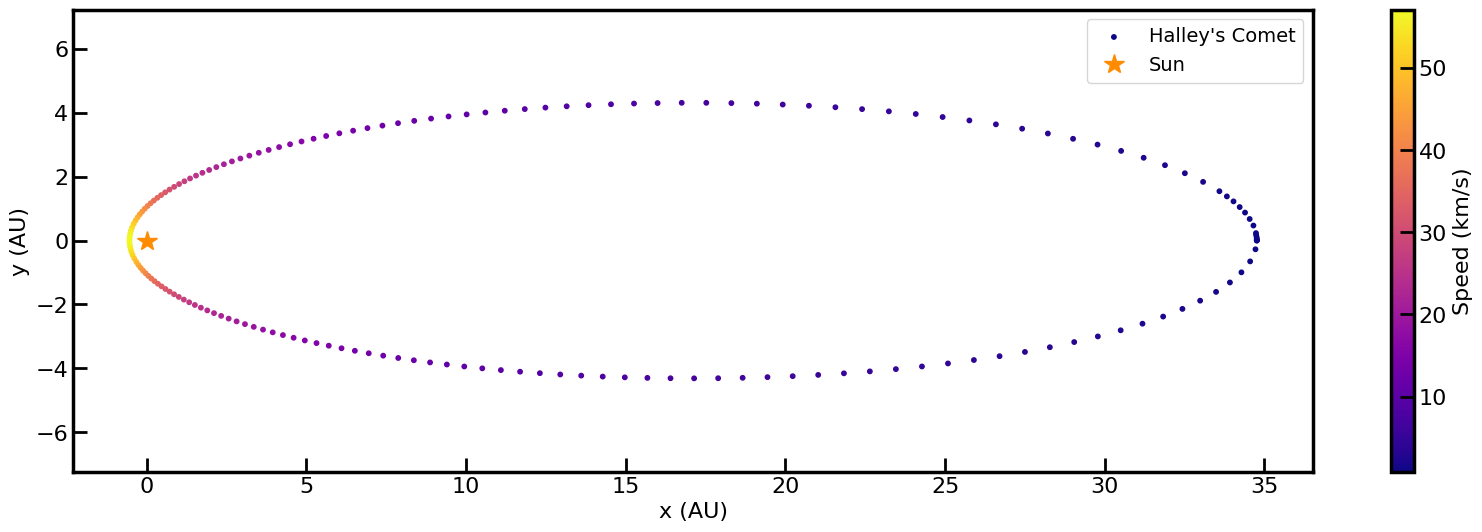

In [8]:
# Setting up the Comet
class Comet:
    # Initialize the Comet with properties
    # initial_pos and initial_vel are the initial position and velocity vectors [x,y] and [vx,vy]
    def __init__(self, name, initial_pos, initial_vel, mass):
        self.name = name
        self.f_vec = np.array(initial_pos + initial_vel, dtype=np.float64)  # [x, y, vx, vy]
        self.history = [self.f_vec.copy()]
        self.energies = []  # Store KE, PE, and Total Energy
        self.dt_values = []  # Store time-steps
        self.time_values = []  
        self.mass = mass

    # Compute the acceleration of the comet
    def acceleration(self, f):
        x, y, vx, vy = f
        r2 = x**2 + y**2
        r = np.sqrt(r2)
        if r > 1e-12:
            ax = -G * M_sun * x / (r2 * r)
            ay = -G * M_sun * y / (r2 * r)
        else:
            ax = ay = 0.0
        return np.array([vx, vy, ax, ay], dtype=np.float64)
    
    # Compute the energy of the comet
    def compute_energy(self):
        x, y, vx, vy = self.f_vec
        r = np.sqrt(x**2 + y**2)
        v2 = vx**2 + vy**2

        KE = 0.5 * self.mass * v2                            # Kinetic Energy
        PE = -G * self.mass * M_sun / r if r > 1e-12 else 0  # Potential Energy - prevent division by 0
        E = KE + PE                                          # Total Energy

        self.energies.append([KE, PE, E])  # Store energy values as a list

# The main class to run the simulation
class Runsimulation:
    def __init__(self, comet, dt_init, end_time, error_tolerance, step_method=None):
        self.comet = comet
        self.dt = dt_init
        self.end_time = end_time
        self.error_tolerance = error_tolerance
        self.step_method = step_method if step_method else self.rk4_step  # Default to RK4

    def rk4_step(self, f, dt):
        error = 0.0 
        k1 = dt * self.comet.acceleration(f)
        k2 = dt * self.comet.acceleration(f + 0.5 * k1)
        k3 = dt * self.comet.acceleration(f + 0.5 * k2)
        k4 = dt * self.comet.acceleration(f + k3)
        f_next = f + (k1 + 2 * k2 + 2 * k3 + k4) / 6.0
        return f_next, f_next, error # Need to ensure 3 values outputted for later use
    
    def adaptive_step(self, body, second_input=None):
        # Adaptive step method can take second input (useful later on and optional)
        while True:
            f_orig = body.f_vec.copy()
            # Use the step method (RK4 or RKF45). Only need one value
            f_full, _, _ = self.step_method(f_orig, self.dt)
            f_half1, _, _ = self.step_method(f_orig, self.dt / 2.0)
            f_half2, _, _ = self.step_method(f_half1, self.dt / 2.0) # Two half steps 
            # Calculate the difference between full and half 
            err_vec = f_full - f_half2
            err = np.linalg.norm(err_vec) / 30.0  # RK4 correction factor

            if err > self.error_tolerance:
                self.dt *= 0.5  # Reduce step size if error is too large
                continue
            else:
                scale = (self.error_tolerance / (err + 1e-10)) ** 0.2
                # Change capped at: 0.5 < dt < 2
                dt_new = self.dt * np.clip(scale, 0.5, 2.0)

                # Accept new state
                body.f_vec, _, _ = self.step_method(f_orig, dt_new)  # Unpacking
                body.history.append(body.f_vec.copy())  # Append new state
                body.compute_energy()  # Record energy at each step

                # Modify step based on second_input (if provided)
                if second_input is not None:
                    dt_new *= second_input  # Example use case

                return dt_new  # Return updated dt

    def run_simulation(self): # Runs simulation with chosen method 
        current_t, steps_taken = 0.0, 0
        start_time = time.time()
        # Run for specified amount of time 
        while current_t < self.end_time:
            self.dt = self.adaptive_step(self.comet)
            current_t += self.dt
            self.comet.time_values.append(current_t)
            self.comet.dt_values.append(self.dt)
            steps_taken += 1

        runtime = time.time() - start_time
        print(f"Simulation finished in {runtime:.2f} s with {steps_taken} steps.") # Used for comparisons 

    # Plot using colour scale 
    def plot_trajectory_speed(self):
        data = np.array(self.comet.history)
        x, y, vx, vy = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
        speed = np.sqrt(vx**2 + vy**2) / 1000.0  # Convert to km/s
        plt.figure(figsize=(20, 6))
        scatter = plt.scatter(x / AU, y / AU, c=speed, cmap='plasma', s=10, label = "Halley's Comet")
        cbar = plt.colorbar(scatter)
        cbar.set_label("Speed (km/s)")
        plt.plot(0, 0, '*', color='darkorange', label='Sun', markersize=15)
        plt.axis('equal')
        plt.xlabel("x (AU)"), plt.ylabel("y (AU)")
        plt.legend(loc = 'upper right')
        plt.show()

    # Plotting the energy and calculating best fit 
    def plot_energy(self):
        if not self.comet.energies or not self.comet.time_values:
            print("No energy data available to plot.")
            return
        energies = np.array(self.comet.energies)
        time_values = np.array(self.comet.time_values) / Year
        min_length = min(len(time_values), len(energies))
        energies = energies[:min_length]
        time_values = time_values[:min_length]
        # Convert to sensible units for the plot 
        KE, PE, E_total = (energies[:, 0] / Year) / 1e16, (energies[:, 1]/ Year) / 1e16, (energies[:, 2]/ Year) / 1e16
        plt.figure(figsize=(20, 6))
        plt.plot(time_values, KE, label="Kinetic Energy", color="blue")
        plt.plot(time_values, PE, label="Potential Energy", color="green")
        plt.plot(time_values, E_total, label="Total Energy", color="black", linestyle="dashed")
        plt.xlabel("Time (Years)")
        plt.ylabel("Energy (x $10^{16}$ J)")
        plt.legend()
        # Calculate best fit for total energy - linear fit = polynomial order 1
        slope, intercept = np.polyfit(time_values, E_total, 1)
        print(f"Slope of Total energy = {slope * 1e16/ Year:.4e} J/year\n")
        plt.legend(loc = 'upper right')
        plt.show()

    # Plotting the time steps (dt) over time ()
    def plot_time_steps(self):
        time_years = np.array(self.comet.time_values) / Year
        dt_years = np.array(self.comet.dt_values) / Year
        plt.figure(figsize=(20, 6))
        plt.plot(time_years, dt_years, label="Adaptive Time Step", color="purple")
        plt.xlabel("Time (Years)")
        plt.ylabel("Time Step (Years)")
        plt.legend(loc = 'upper right')
        plt.show()

# Running simulation. Define Comet and starting conditions. Rough Mass used as mainly concerned with conservation of E
comet = Comet(name = "Halley", 
              initial_pos = [r_aphelion, 0], 
              initial_vel = [0, v_aphelion], 
              mass=2.2e14)
sim_rk4 = Runsimulation(comet, 
                        dt_init = Year / 100,   # Initial time interval 
                        end_time = Year * 80,   # Total time to run simulation for 
                        error_tolerance = 1000)         # In m/s not km/s! Lower = more regular intervals 
sim_rk4.run_simulation()  # Uses RK4 by default
sim_rk4.plot_trajectory_speed()

Simulation finished in 0.27 s with 2898 steps.
Slope of Total energy = -1.3071e+00 J/year



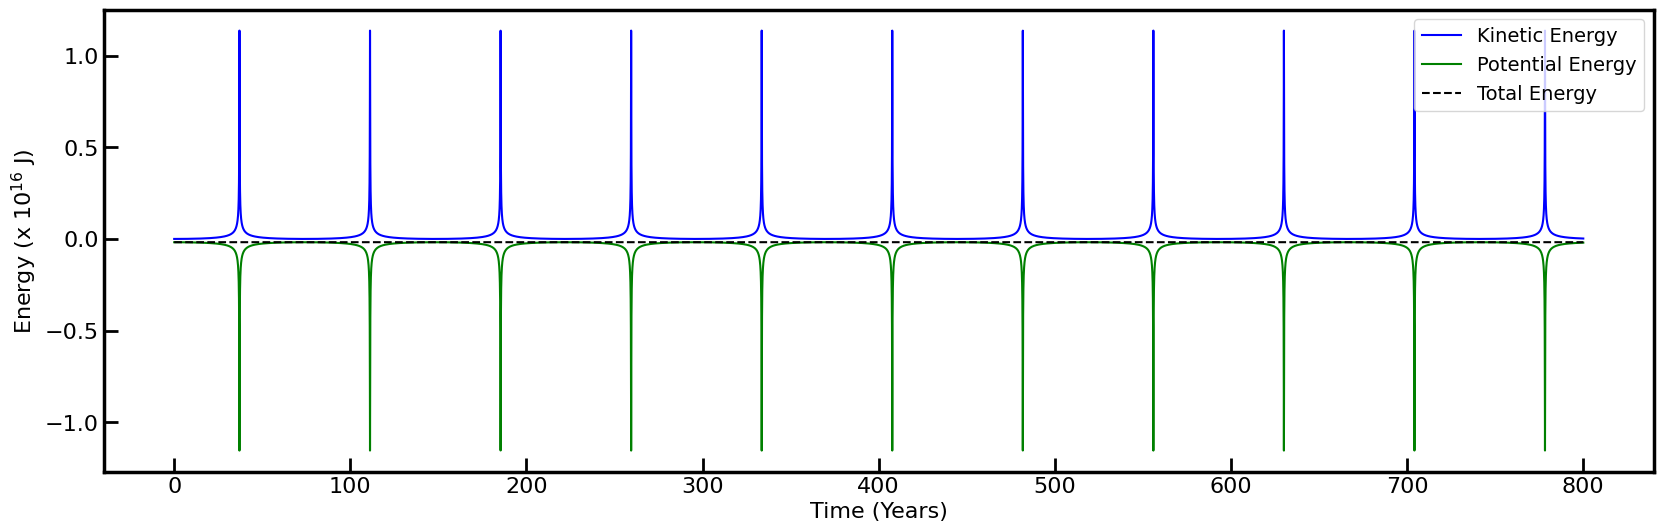

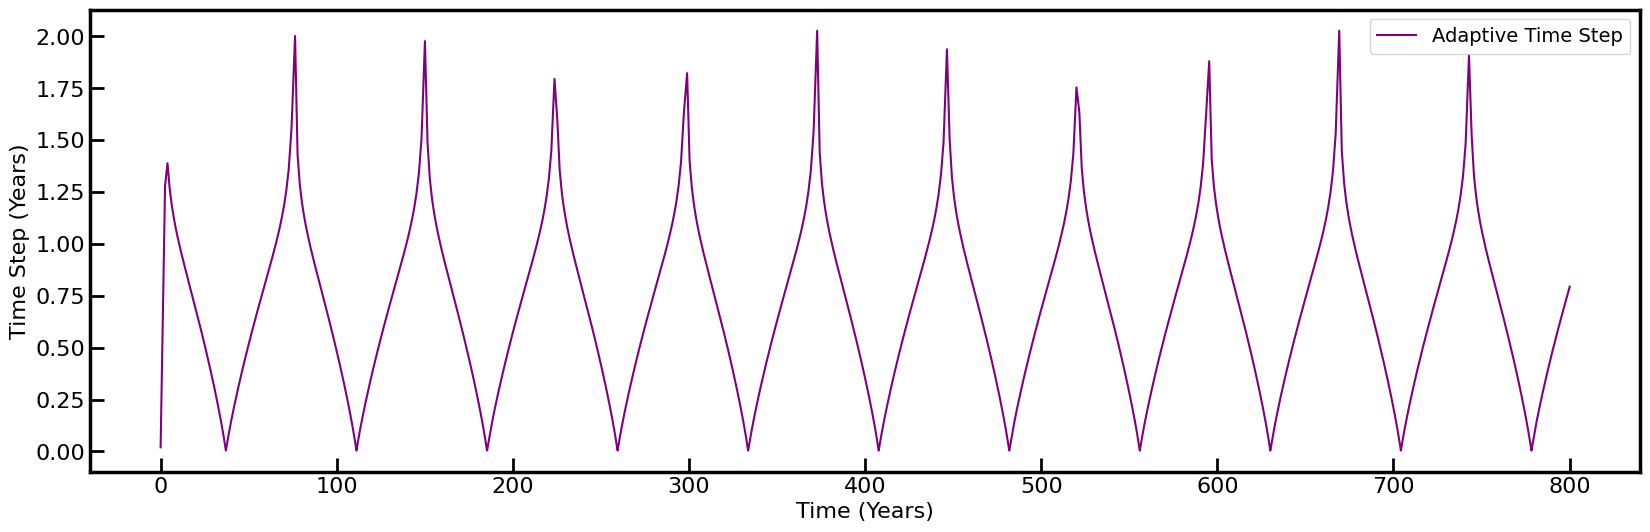

In [9]:
# Re-create Comet and Simulation - clears all arrays and resets system
# Example visulisation of 800 year simulation 
comet = Comet(name = "Halley", 
              initial_pos = [r_aphelion, 0], 
              initial_vel = [0, v_aphelion], 
              mass = 2.2e14)

sim_rk4_2 = Runsimulation(comet, 
                          dt_init = Year / 100, # Initial dt 
                          end_time = Year * 800,# 800 year simulation 
                          error_tolerance = 100)        # Lower = closer spacing 

sim_rk4_2.run_simulation()        
sim_rk4_2.plot_energy()
sim_rk4_2.plot_time_steps()  

### RKF45 

The code below implements the Runge-Kutta Fehlberg (RKF45) method, outlined further in the report. The code utilises many properties from above, adapting slightly to run with the improved method. The output shows that the RKF45 uses fewer steps for the same result, increasing the speed and requiring less computing power. This means, a more sensitive tolerance can be used while mainting processing speed, making the overall plot more accurate for the same computational cost. 

In [10]:
# Comet class remains the same - only changing the method used 
class RunsimulationRKF45(Runsimulation): # Inherit parameters from above 
    def __init__(self, comet, dt_init, end_time, error_tolerance):
        super().__init__(comet, dt_init, end_time, error_tolerance, step_method = self.rkf45_step)

    #Define the new method - RKF45
    def rkf45_step(self, f, dt):
        # Computes extra terms and uses Fehlberg coefficients 
        k1 = dt * self.comet.acceleration(f)
        k2 = dt * self.comet.acceleration(f + k1 * 1/4)
        k3 = dt * self.comet.acceleration(f + k1 * 3/32 + k2 * 9/32)
        k4 = dt * self.comet.acceleration(f + k1 * 1932/2197 - k2 * 7200/2197 + k3 * 7296/2197)
        k5 = dt * self.comet.acceleration(f + k1 * 439/216 - k2 * 8 + k3 * 3680/513 - k4 * 845/4104)
        k6 = dt * self.comet.acceleration(f - k1 * 8/27 + k2 * 2 - k3 * 3544/2565 + k4 * 1859/4104 - k5 * 11/40)
        # Compute 4th and 5th-order estimates
        f4 = f + k1 * 25/216 + k3 * 1408/2565 + k4 * 2197/4104 - k5 * 1/5
        f5 = f + k1 * 16/135 + k3 * 6656/12825 + k4 * 28561/56430 - k5 * 9/50 + k6 * 2/55
        # Compute error estimate
        error = np.linalg.norm(f5 - f4)

        return f4, f5, error

Simulation finished in 0.04 s with 111 steps.


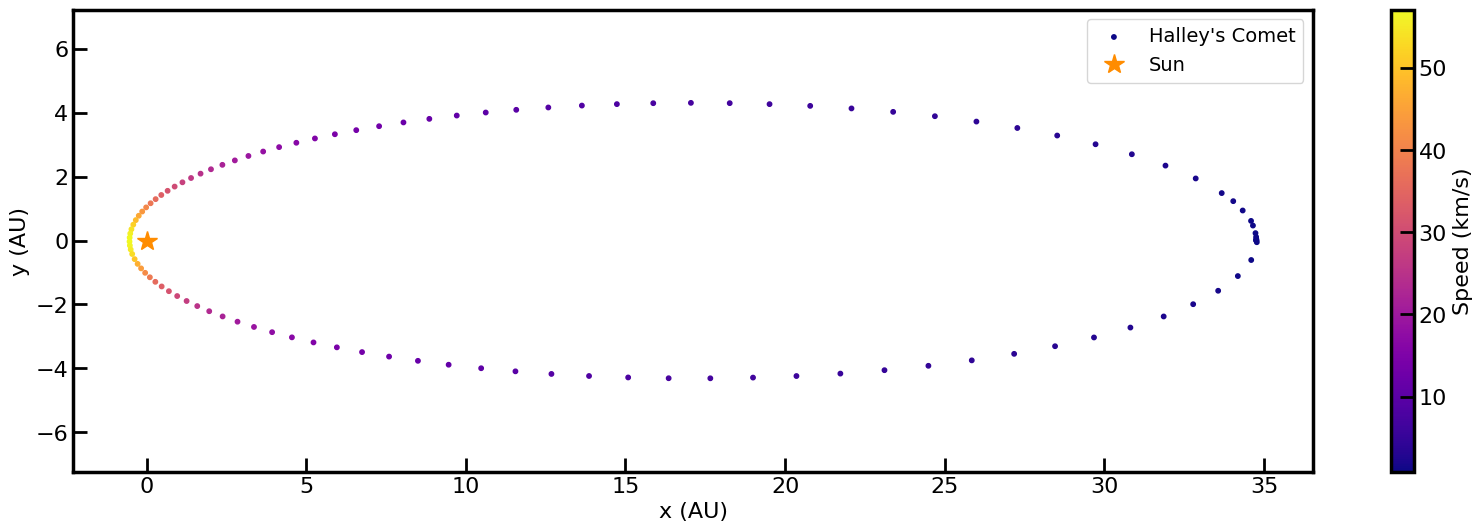

Slope of Total energy = 5.0463e+01 J/year



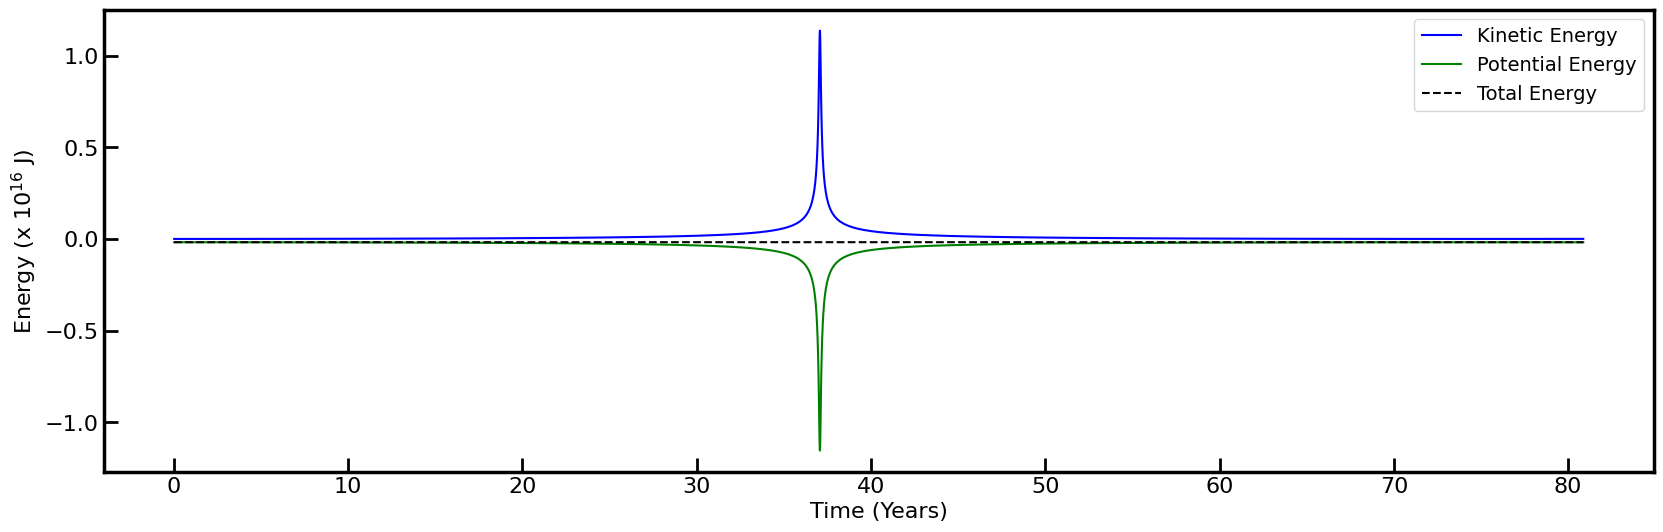

In [11]:
# Run RKF45 without redefining anything
comet = Comet(name = "Halley", 
              initial_pos = [r_aphelion, 0], 
              initial_vel = [0, v_aphelion], 
              mass=2.2e14)

sim_rkf45 = RunsimulationRKF45(comet, 
                               dt_init = Year / 100, 
                               end_time = Year * 80, 
                               error_tolerance = 1000) # m/s

sim_rkf45.run_simulation()        # Uses RKF45 above 
sim_rkf45.plot_trajectory_speed() # Plot speed of comet
sim_rkf45.plot_energy()           # Plot energy of comet

### Velocity - Verlet Method 

The code below implements the velocity-Verlet method, outlined in the report. This method calculates the position of particiles in a system by utilising velocity directly in calculation. While this method uses more steps, it should present a solution that has less energy loss over its cycle, as measured by the gradient of the total energy fit. 

In [12]:
# Comet class remains the same - only changing the method used 
class RunVerlet(Runsimulation): # Inherit parameters from adaptive RK4 method 
    def __init__(self, comet, dt_init, end_time):
        # Verlet method does not need a tolerance so can be set to None 
        super().__init__(comet, dt_init, end_time, error_tolerance = None, step_method=self.verlet_step)

    # Define verlet method 
    def verlet_step(self, f, dt):
        x, y, vx, vy = f
        # Compute acceleration at current position
        a_current = self.comet.acceleration(f)[2:]  # [ax, ay]
        # Update positions and temporaily store them
        x_new = x + vx * dt + 0.5 * a_current[0] * dt**2
        y_new = y + vy * dt + 0.5 * a_current[1] * dt**2
        f_temp = np.array([x_new, y_new, vx, vy], dtype=np.float64) 
        # Acceleration at the new position
        a_next = self.comet.acceleration(f_temp)[2:]  
        # Update velocities
        vx_new = vx + 0.5 * (a_current[0] + a_next[0]) * dt
        vy_new = vy + 0.5 * (a_current[1] + a_next[1]) * dt

        return np.array([x_new, y_new, vx_new, vy_new], dtype=np.float64), None, None  

    # Need to adapt the adaptive_step() to not use error estimate 
    def adaptive_step(self, body):
        f_new, _, _ = self.step_method(self.comet.f_vec, self.dt)
        self.comet.f_vec = f_new
        self.comet.history.append(f_new.copy())
        self.comet.compute_energy()
        # Fixed step size, so dt remains unchanged
        return self.dt  

Simulation finished in 0.08 s with 7600 steps.


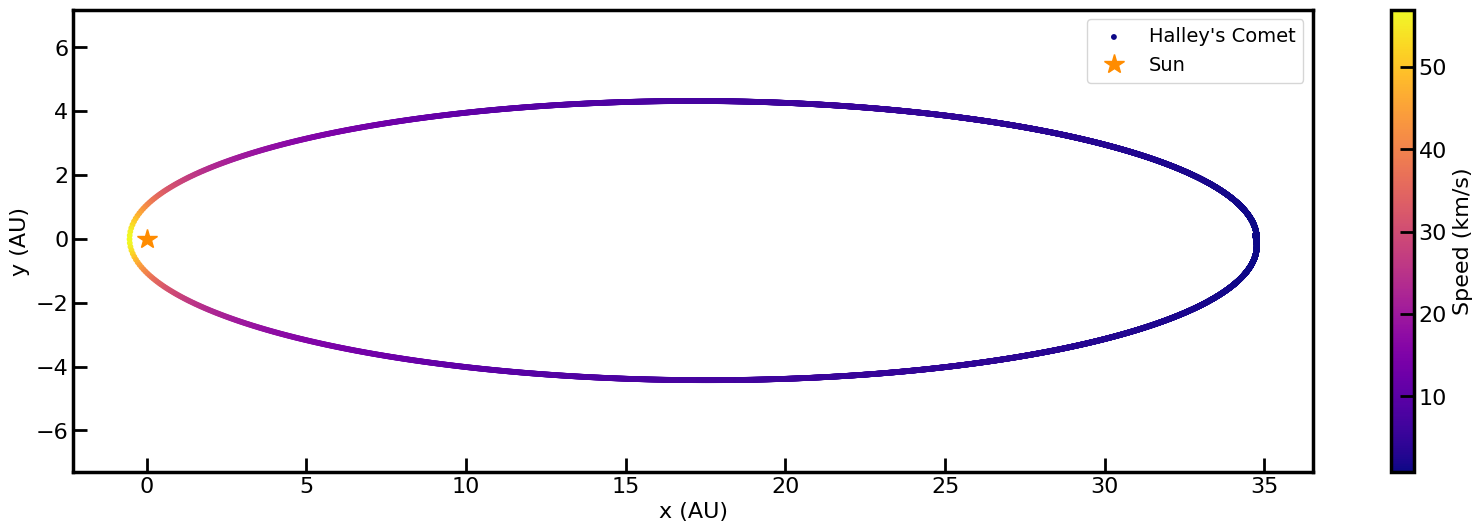

Slope of Total energy = 1.0433e+00 J/year



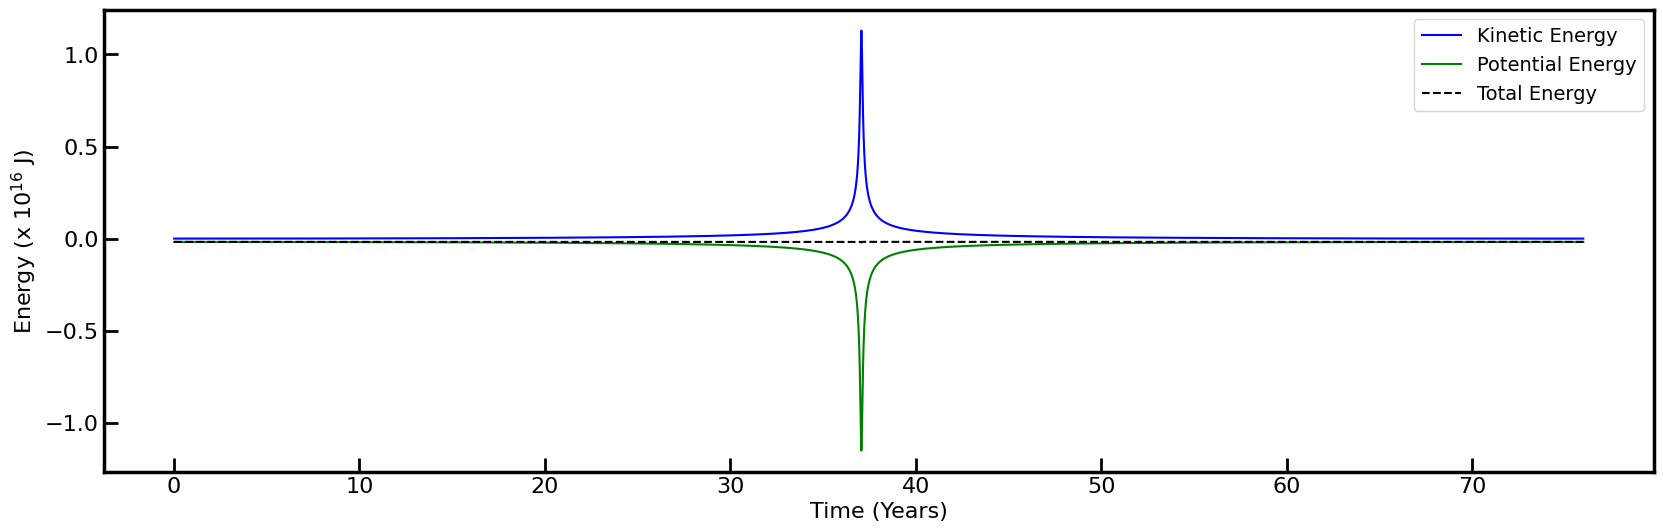

In [13]:
# Create Comet and Simulation
comet = Comet("Halley", 
              [r_aphelion, 0], 
              [0, v_aphelion], 
              mass = 2.2e14)

sim = RunVerlet(comet, 
                dt_init=Year / 100, 
                end_time=Year * 76)

sim.run_simulation()          # Uses Verlet integration
sim.plot_trajectory_speed()   # Plot orbit coloured by speed
sim.plot_energy()             # Plot energy evolution

The code above represented the solution to question 1 of the coursework. This point onwards is now providing a solution to question 2. 

# Q2a - Three Body Simulation 

This questions focuses on a three body simulation, of two objects orbiting around a fixed central mass. The central object is a star of mass M (one solar mass) orbited by two planets of masses given by 
$$ m_1 / M = 10^{-3} , \space \space m_2 / M = 4 \times 10^{-2}$$

The orbits were modelled using the adaptive RK4 method. Circular orbits were modelle at values $a_1 = 2.52$ AU and $a_2 = 5.24$ AU. The starting values of velocity were calculted at initiation. The model also offers the extension to model the orbits of Jupiter and Saturn around the Star, using the values:\
$M_{Jupiter} = 1.898 \times 10^{27}$ kg\
$a_{Jupiter} = 5.204 $ AU\
$M_{Saturn} = 5.683 \times 10^{26}$ kg\
$a_{Saturn} = 9.583$ AU

It is evident from the plot below, that the orbits of both Jupiter and Saturn are much less elliptical than that of Halley's Comet. This is as expected given the eccentricity values are $e_{Jupiter} = 0.049$ and $e_{Saturn} = 0.057.$

Simulation finished in 0.30 s with 1569 steps.
Simulation finished in 0.13 s with 614 steps.


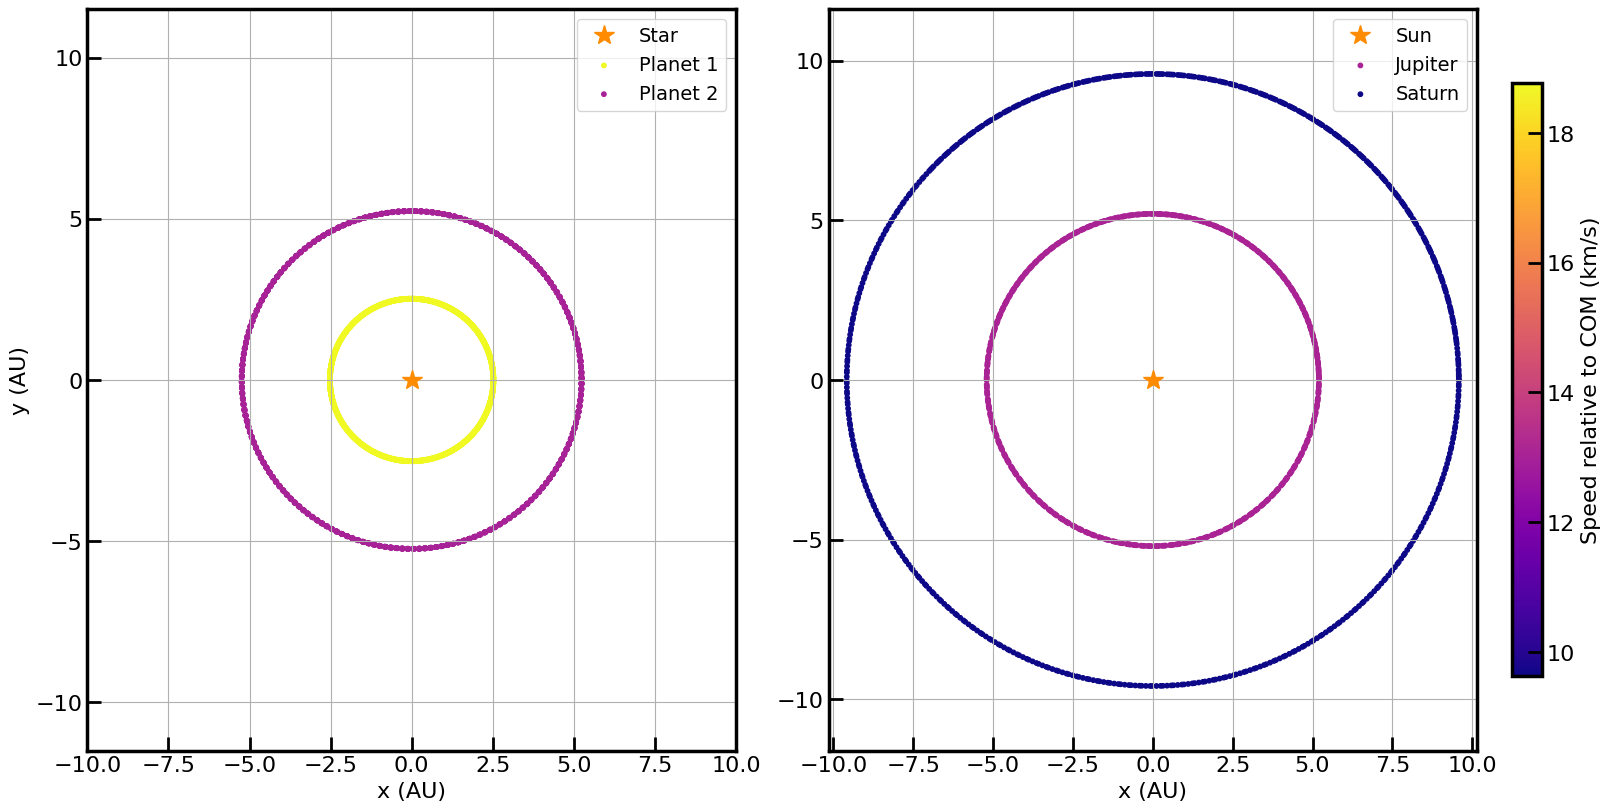

In [14]:
class Planet(Comet):
    def __init__(self, name, a, mass):
        # Inherit from Comet and add semi-major axis
        super().__init__(name, [a, 0.0], [0.0, np.sqrt(G * M_sun / a)], mass)

class SolarSystemSimulation(Runsimulation):
    def __init__(self, planets, dt_init, end_time, error_tolerance, step_method=None):
        # Inherti from Runsimulation and add multiple planets
        self.planets = planets
        self.step_method = step_method or self.rk4_step  # Default to RK4
        super().__init__(planets[0], dt_init, end_time, error_tolerance)  # Use first planet for setup

    # Redefine adaptive step to handle multiple planets
    def run_simulation(self):
        current_t, steps_taken = 0.0, 0
        start_time = time.time()
        while current_t < self.end_time:
            dt_list = []  # Store time steps for each planet
            for planet in self.planets:
                dt_list.append(self.adaptive_step(planet))  # Compute dt for each planet
            self.dt = min(dt_list)  # Use smallest dt to maintain accuracy
            current_t += self.dt
            steps_taken += 1
        runtime = time.time() - start_time
        print(f"Simulation finished in {runtime:.2f} s with {steps_taken} steps.")

    # Plot orbits of planets coloured by speed
    def plot_orbits_with_speed(self, planets_1_2, planets_jupiter_saturn):
        fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)
        # Collect all speeds so can compare 
        all_speeds = []
        for planet in planets_1_2 + planets_jupiter_saturn:
            data = np.array(planet.history)
            vx, vy = data[:, 2], data[:, 3]
            speeds = np.sqrt(vx**2 + vy**2) / 1000  # Convert m/s to km/s
            all_speeds.extend(speeds)

        vmin, vmax = min(all_speeds), max(all_speeds)  # Used for the shared colour scale

        norm = colors.Normalize(vmin=vmin, vmax=vmax) # Normalize the colour scale
        sm = cm.ScalarMappable(cmap = cm.plasma, norm=norm)
        sm.set_array([])  # Required for colourbar

        # Will have two subplots side-by-side with Star / Sun at the centre 
        axs[0].plot(0, 0, '*', color='darkorange', label='Star', markersize=15)
        axs[1].plot(0, 0, '*', color='darkorange', label='Sun', markersize=15)
        # First plot
        for planet in planets_1_2:
            data = np.array(planet.history)
            x, y = data[:, 0] / AU, data[:, 1] / AU
            vx, vy = data[:, 2], data[:, 3]
            speeds = np.sqrt(vx**2 + vy**2) / 1000  # Convert to km/s
            axs[0].scatter(x, y, c=speeds, cmap=cm.plasma, s=10, norm=norm, label=planet.name)
        axs[0].set_xlabel("x (AU)")
        axs[0].set_ylabel("y (AU)")
        axs[0].legend(loc="upper right")
        axs[0].set_ylim(-11.5, 11.5)
        axs[0].set_xlim(-10, 10)
        axs[0].grid(True)

        # Second subplot
        for planet in planets_jupiter_saturn:
            data = np.array(planet.history)
            x, y = data[:, 0] / AU, data[:, 1] / AU
            vx, vy = data[:, 2], data[:, 3]
            speeds = np.sqrt(vx**2 + vy**2) / 1000  # Convert to km/s
            axs[1].scatter(x, y, c=speeds, cmap=cm.plasma, s=10, norm=norm, label=planet.name)
        axs[1].set_xlabel("x (AU)")
        axs[1].legend(loc="upper right")
        axs[1].axis("equal")
        axs[1].grid(True)

        # Shared colourbar
        cbar = fig.colorbar(sm, ax=axs, orientation='vertical', shrink=0.8, pad=0.02)
        cbar.set_label("Speed relative to COM (km/s)", rotation=90)
        plt.show()

# Define and create planets
planet_data = {
    'Planet 1': (2.52 * AU, 1e-3 * M_sun),
    'Planet 2': (5.24 * AU, 4e-2 * M_sun),
    'Jupiter': (5.2 * AU, 1.898e27),
    'Saturn': (9.58 * AU, 5.683e26)
}

planet_objects = [Planet(name, *data) for name, data in planet_data.items()]

# Run simulations
sim_planet_1_2 = SolarSystemSimulation(planet_objects[:2], 
                                       dt_init=Year / 100, 
                                       end_time=Year * 100, 
                                       error_tolerance=1000)
sim_jupiter_saturn = SolarSystemSimulation(planet_objects[2:], 
                                           dt_init=Year / 100, 
                                           end_time=Year * 100, 
                                           error_tolerance =1000)

# Run and plot
sim_planet_1_2.run_simulation()
sim_jupiter_saturn.run_simulation()
sim_planet_1_2.plot_orbits_with_speed(planet_objects[:2], planet_objects[2:])

# Q2b - Centre of Mass frame

The below code aims to transform the coordinate system to a frame based on the centre of mass of the system. Given that this problem requires a lot of adaptations from before, the program has been designed to operate standalone, that is it will run without the classes previously defined. 

In [15]:
# Class for Celestial Bodies with properties and state vector in SI units
class CelestialBody:
    def __init__(self, name, mass, initial_pos, initial_vel):
        self.name = name
        self.mass = mass
        self.state_vec = np.array(initial_pos + initial_vel, dtype=np.float64)
        self.state_history = [self.state_vec.copy()]  # Keep track of all states
        self.energy_history = []  # Store kinetic, potential, and total energy
        self.dt_history = []      # Store time-step sizes
        self.time_history = []    # Store simulation time values

    # Compute net gravitational acceleration from other bodies. 
    def acceleration(self, all_bodies):
        x, y, vx, vy = self.state_vec
        ax, ay = 0.0, 0.0

        for other_body in all_bodies:
            if other_body is self:
                continue
            xj, yj, vxj, vyj = other_body.state_vec
            m_j = other_body.mass

            dx = xj - x
            dy = yj - y
            r2 = dx**2 + dy**2
            if r2 > 1e-12:
                r = np.sqrt(r2)
                accel_factor = G * m_j / (r2 * r)  # G*m_j / r^3
                ax += accel_factor * dx
                ay += accel_factor * dy

        return np.array([vx, vy, ax, ay], dtype=np.float64)
   
    # Calculating energy per body 
    def compute_energy(self, all_bodies):
        x, y, vx, vy = self.state_vec
        speed_sq = vx**2 + vy**2
        KE = 0.5 * self.mass * speed_sq  # Kinetic Energy
        PE = 0.0 # Initially

        for other_body in all_bodies:
            if other_body is self:
                continue
            xj, yj, _, _ = other_body.state_vec
            m_j = other_body.mass
            dx, dy = xj - x, yj - y
            r = np.sqrt(dx**2 + dy**2)
            if r > 1e-12:
                PE += -G * self.mass * m_j / r

        E = KE + PE # Total Energy
        self.energy_history.append([KE, PE, E])

# The main class for the multi-body simulation
class MultiBodySimulation:
    def __init__(self, bodies, dt_init, end_time, error_tolerance):
        self.bodies = bodies
        self.dt = dt_init
        self.end_time = end_time
        self.error_tolerance = error_tolerance
        self.shift_to_centre_of_mass()

    # Compute where the centre of mass is for the system 
    def compute_centre_of_mass(self):
        total_mass = sum(body.mass for body in self.bodies)
        pos_cm = np.zeros(2)
        vel_cm = np.zeros(2)

        for body in self.bodies:
            pos_cm += body.mass * body.state_vec[:2]
            vel_cm += body.mass * body.state_vec[2:]

        return pos_cm / total_mass, vel_cm / total_mass
    
    # Compute the velocity of the center of mass at a given index in history.
    def compute_com_velocity(self, index):
        total_mass = sum(body.mass for body in self.bodies)
        # X and Y components of the velocity of the center of mass
        vx_cm = sum(body.mass * body.state_history[index][2] for body in self.bodies) / total_mass
        vy_cm = sum(body.mass * body.state_history[index][3] for body in self.bodies) / total_mass
        return np.array([vx_cm, vy_cm])

    # Shift bodies so COM is at the Origin and has zero net velocity
    def shift_to_centre_of_mass(self):
        r_cm, v_cm = self.compute_centre_of_mass()
        for body in self.bodies:
            body.state_vec[:2] -= r_cm
            body.state_vec[2:] -= v_cm
            # Reset the history to reflect the shift
            body.state_history = [body.state_vec.copy()]

    # Get the system state vectors as a flattened array
    def get_system_state(self):
        return np.concatenate([body.state_vec for body in self.bodies])

    # Update each body's state vector from a single flattened array
    def set_system_state(self, flat_state):
        for i, body in enumerate(self.bodies):
            body.state_vec = flat_state[4*i : 4*i + 4]

    # Compute velocity of each body relative to the center of mass at a given history index.
    def compute_relative_speeds(self, index):
        com_vel = self.compute_com_velocity(index)
        rel_speed_dict = {}
        for body in self.bodies:
            vx, vy = body.state_history[index][2], body.state_history[index][3]
            v_rel = np.sqrt((vx - com_vel[0])**2 + (vy - com_vel[1])**2)
            rel_speed_dict[body.name] = v_rel
        return rel_speed_dict

    # Compute derivatives for all bodies at once [vx, vy, ax, ay]
    def compute_derivatives(self, flat_state):
        self.set_system_state(flat_state)
        derivatives = []
        for body in self.bodies:
            derivatives.append(body.acceleration(self.bodies))
        return np.concatenate(derivatives)

    # Standard RK4 step just for whole system now 
    def rk4_step(self, state_array, dt):
        k1 = dt * self.compute_derivatives(state_array)
        k2 = dt * self.compute_derivatives(state_array + 0.5 * k1)
        k3 = dt * self.compute_derivatives(state_array + 0.5 * k2)
        k4 = dt * self.compute_derivatives(state_array + k3)

        return state_array + (k1 + 2*k2 + 2*k3 + k4) / 6.0

    # Adaptive RK4 step for the whole system
    def adaptive_rk4_step(self):
        while True:
            original_state = self.get_system_state()
            # Hard code rk4 method for this 
            full_step_state = self.rk4_step(original_state, self.dt)
            half_step_1 = self.rk4_step(original_state, self.dt / 2.0)
            half_step_2 = self.rk4_step(half_step_1, self.dt / 2.0)
            # Calculate the difference between full and half 
            error_vec = full_step_state - half_step_2
            local_error = np.linalg.norm(error_vec) / 30.0 # 30 = RK4 correction factor

            if local_error > self.error_tolerance:
                self.dt *= 0.5 # Reduce step size if error is too large
                continue
            else:
                scaling_factor = (self.error_tolerance / (local_error + 1e-10)) ** 0.2
                # Change capped at: 0.5 < dt < 2
                self.dt = self.dt * np.clip(scaling_factor, 0.5, 2.0)
                # Final update using the adjusted dt
                new_state = self.rk4_step(original_state, self.dt)
                self.set_system_state(new_state)
                # Record new state and compute energy for each body
                for body in self.bodies:
                    body.state_history.append(body.state_vec.copy())
                    body.compute_energy(self.bodies)

                return self.dt

    # Run the simulation for the specified time
    def run_simulation(self):
        current_time, steps_taken = 0.0, 0
        start_time = time.time()
        # Run for specified amount of time
        while current_time < self.end_time:
            # Perform one adaptive step
            updated_dt = self.adaptive_rk4_step()
            current_time += updated_dt
            # Store time and dt for each body
            for body in self.bodies:
                body.time_history.append(current_time)
                body.dt_history.append(updated_dt)

            steps_taken += 1

        runtime = time.time() - start_time
        print(f"Simulation finished in {runtime:.2f} s with {steps_taken} steps.")

    # Plotting the trajectories of all bodies with colour-coded speeds
    def plot_trajectory_speed(self):
        fig, ax = plt.subplots(figsize=(14, 6))
        # Dont want the same markers 
        custom_markers = {"Star": "*", "Planet 1": "^", "Planet 2": "x", "Jupiter": "D", "Saturn": "v",}

        # Collect speeds for a shared colour scale
        data = []
        for idx in range(len(self.bodies[0].state_history)):
            com_vel = self.compute_com_velocity(idx)
            for body in self.bodies:
                vx, vy = body.state_history[idx][2], body.state_history[idx][3] # Extract velocities
                # Compute relative speed to the center of mass
                v_rel = np.sqrt((vx - com_vel[0])**2 + (vy - com_vel[1])**2)
                data.append(v_rel) # Store all speeds

        # Convert to numpy array and get min/max for colour scale
        data = np.array(data)
        vmin, vmax = data.min() / 1000.0, data.max() / 1000.0

        # Plot orbits - loop over all bodies
        for body in self.bodies:
            data = np.array(body.state_history)
            # Extract x and y positions - convert to AU
            x_vals, y_vals = data[:, 0] / AU, data[:, 1] / AU
            rel_speeds = []
            for idx in range(len(body.state_history)):
                com_vel = self.compute_com_velocity(idx)
                vx, vy = body.state_history[idx][2], body.state_history[idx][3]
                # Compute relative speed to the center of mass
                v_rel = np.sqrt((vx - com_vel[0])**2 + (vy - com_vel[1])**2)
                # Convert to km/s
                rel_speeds.append(v_rel / 1000.0)
            # Use custom markers for each body
            marker_style = custom_markers.get(body.name, "o")
            sc = ax.scatter(x_vals, y_vals, c=rel_speeds, s=10, cmap='plasma',
                            vmin=vmin, vmax=vmax, marker=marker_style, label=body.name)
        # Add the colourbar
        cbar = plt.colorbar(sc, ax=ax)
        cbar.set_label("Speed relative to COM (km/s)", rotation=90)
        ax.set_xlabel("x (AU)")
        ax.set_ylabel("y (AU)")
        ax.axis('equal')
        ax.grid(True)
        ax.legend(loc = 'upper right')

        plt.show()

Simulation finished in 0.25 s with 806 steps.


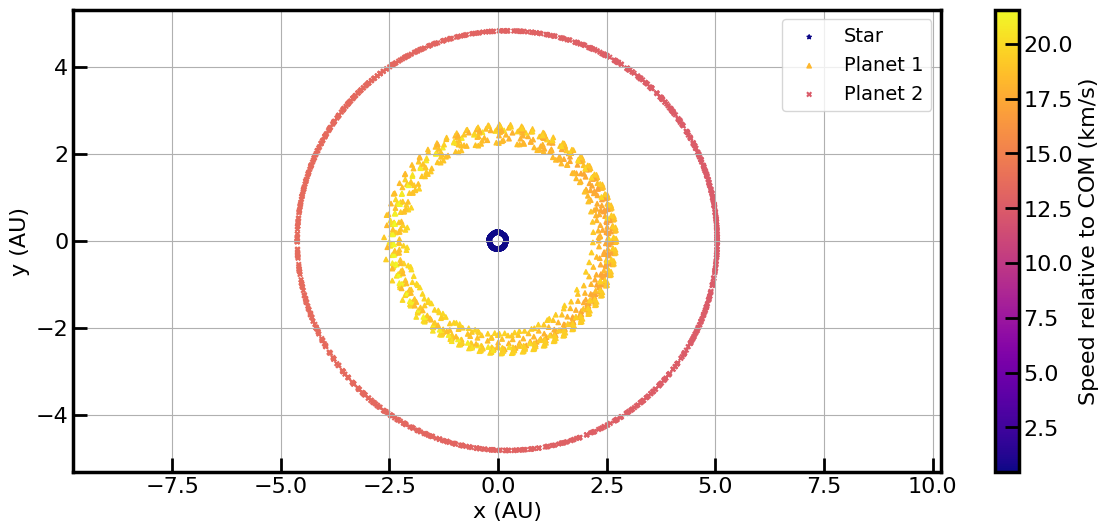

In [16]:
# Example usage - define the bodies required for the simulation
# Main star, two planets, Jupiter, and Saturn
star = CelestialBody(name = "Star", 
                     mass = M_sun, 
                     initial_pos = [0.0, 0.0], 
                     initial_vel = [0.0, 0.0])

Jupiter = CelestialBody(name = "Jupiter", 
                        mass = 1.898e27, 
                        initial_pos = [5.2 * AU, 0.0],
                        initial_vel = [0.0, np.sqrt(G * M_sun / (5.2 * AU))])

Saturn = CelestialBody(name = "Saturn", 
                       mass = 5.683e26, 
                       initial_pos = [9.58 * AU, 0.0],
                       initial_vel = [0.0, np.sqrt(G * M_sun / (9.58 * AU))])

planet1 = CelestialBody(name = "Planet 1",
                        mass = 1e-3 * M_sun, 
                        initial_pos = [2.52 * AU, 0.0],
                        initial_vel = [0.0, np.sqrt(G * M_sun / (2.52 * AU))])

planet2 = CelestialBody(name = "Planet 2", 
                        mass = 4e-2 * M_sun, 
                        initial_pos = [5.24 * AU, 0.0],
                        initial_vel = [0.0, np.sqrt(G * M_sun / (5.24 * AU))])

# List of all bodies
body_list = [star, planet1, planet2]

# Create and run the simulation
simulation = MultiBodySimulation(body_list, dt_init=Year / 100, 
                                 end_time = 50 * Year, 
                                 error_tolerance=1000)
simulation.run_simulation()
# Plot the trajectories with speed color-coding
simulation.plot_trajectory_speed()

The below code is an example of how this can be used to demonstrate the orbits of binary stars, one with a planet orbiting it. 

Simulation finished in 0.44 s with 1550 steps.


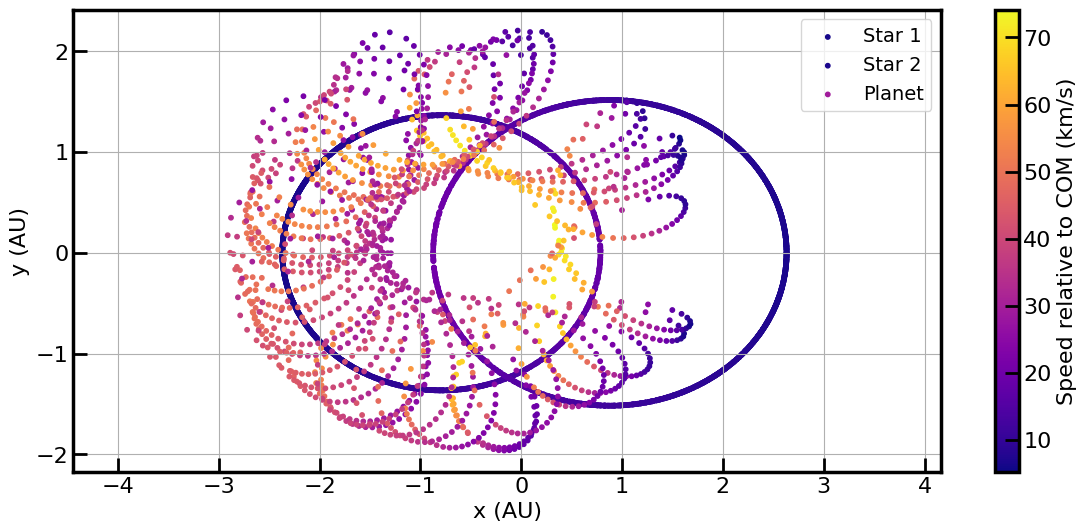

In [17]:
M_star1 = M_sun
M_star2 = 0.9 * M_sun
a_binary = 5 * AU  # Separation between stars

# Compute distances from center of mass
r_star1 = (M_star2 / (M_star1 + M_star2)) * a_binary
r_star2 = (M_star1 / (M_star1 + M_star2)) * a_binary

# Compute orbital velocities for a stable binary system
v_star1 = np.sqrt(G * M_star2 / a_binary) * (r_star2 / a_binary)
v_star2 = np.sqrt(G * M_star1 / a_binary) * (r_star1 / a_binary)

# Place stars symmetrically around the center of mass
star1 = CelestialBody(name = "Star 1", 
                      mass = M_sun, 
                      initial_pos = [-r_star1, 0], 
                      initial_vel = [0, v_star1])  # Counterclockwise

star2 = CelestialBody(name = "Star 2", 
                      mass = 0.9 * M_sun, 
                      initial_pos = [r_star2, 0], 
                      initial_vel = [0, -v_star2])  # Clockwise

# Define a planet orbiting one of the stars
planet = CelestialBody(name = "Planet", 
                       mass = 1e-20 * M_sun, 
                       initial_pos = [-r_star1 + 1 * AU, 0], 
                       initial_vel = [0, np.sqrt(G * M_star1 / (1 * AU))])

# Create the binary star system
bodies = [star1, star2, planet]

# Run the simulation
sim = MultiBodySimulation(bodies, dt_init=Year/100, end_time=20*Year, error_tolerance=1000)
sim.run_simulation()

# Plot the system
sim.plot_trajectory_speed()

END OF REPORT

----------------------------------------------------------------------------------------------------------------------------